In [1]:
import pandas as pd
import numpy as np
from keras.datasets import boston_housing 
from keras import models, layers, optimizers

In [2]:
(train_data , train_targets) ,(test_data,test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [5]:
train_data.shape

(404, 13)

In [3]:
train_data[1]

array([2.1770e-02, 8.2500e+01, 2.0300e+00, 0.0000e+00, 4.1500e-01,
       7.6100e+00, 1.5700e+01, 6.2700e+00, 2.0000e+00, 3.4800e+02,
       1.4700e+01, 3.9538e+02, 3.1100e+00])

In [4]:
#valor en miles de dolares para la casa
train_targets[1]

42.3

los datos tienen un rango muy amplio entre ellos, por ende es necesario normalizarlos

In [6]:
#restamos la media y dividimos por la desviación, ahora todos los datos están entre 0 y 1
mean = train_data.mean(axis=0)
train_data = train_data  - mean
std = train_data.std(axis=0)
train_data = train_data / std


#por etica hacemos el proceso de los datos de prueba con los valores de los datos de entrenamiento
#se evidencia que estos valores si superan los rangos de 0 y 1 
test_data = test_data - mean
test_data = test_data / std

print(train_data[0])
print(test_data[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]
[ 1.55369355 -0.48361547  1.0283258  -0.25683275  1.03838067  0.23545815
  1.11048828 -0.93976936  1.67588577  1.5652875   0.78447637 -3.48459553
  2.25092074]


###Definiendo nuestra red

In [7]:
def build_model_regression(input_data):
    model = models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(input_data,)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
    return model

###K - fold validation

este metodo es mas para evaluar como es el desempeño respecto a la data de validación y cuantas epocas deberia iterar y con que parametros… una vez se analize la grafica y se vea los resultados se puede entrenar un modelo de cero con los parametros que consegui… todo esto sin necesidad de usar el kfold validation.

In [27]:
k = 4
num_val_samples = len(train_data) // 4
num_epoch = 55
all_history = []

In [28]:
for i in range(k):
    print("Fold ", i)
    print("intervalo de datos de prueba: ", i *
          num_val_samples, " ", (i+1) * num_val_samples)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i+1) * num_val_samples:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i+1) * num_val_samples:]],
        axis=0
    )
    model = build_model_regression(13)
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epoch, batch_size = 16,
                        validation_data = (val_data, val_targets),
                        verbose=0)
    all_history.append(history.history['val_mae'])


Fold  0
intervalo de datos de prueba:  0   101
Fold  1
intervalo de datos de prueba:  101   202
Fold  2
intervalo de datos de prueba:  202   303
Fold  3
intervalo de datos de prueba:  303   404


### Visualizando resultados

In [29]:
all_mae_avg = pd.DataFrame(all_history).mean(axis=0)

In [30]:
all_mae_avg

0     19.173742
1     15.700365
2     11.434373
3      7.713797
4      5.800169
5      4.891695
6      4.273491
7      3.901688
8      3.612010
9      3.454427
10     3.272416
11     3.183590
12     3.065685
13     2.981493
14     2.886243
15     2.843915
16     2.774559
17     2.756212
18     2.696981
19     2.722025
20     2.683504
21     2.669873
22     2.599389
23     2.589849
24     2.596092
25     2.599670
26     2.553604
27     2.533006
28     2.507801
29     2.491032
30     2.488728
31     2.487847
32     2.464665
33     2.487983
34     2.457501
35     2.453985
36     2.460388
37     2.444064
38     2.448657
39     2.426959
40     2.429791
41     2.415453
42     2.442587
43     2.409780
44     2.403040
45     2.425488
46     2.359211
47     2.418271
48     2.399694
49     2.364393
50     2.391401
51     2.397505
52     2.383773
53     2.353645
54     2.349561
dtype: float64

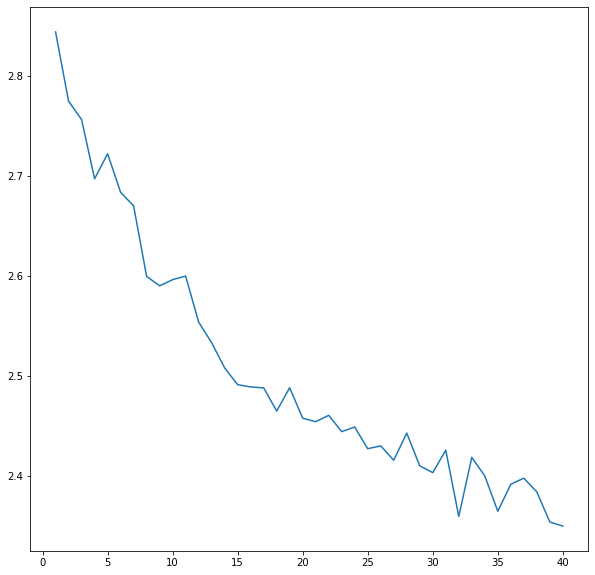

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.plot(range(1,len(all_mae_avg[15:])+1), all_mae_avg[15:])
plt.show()

In [32]:
#tenemos un error de aprox 3 mil dolares
model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 19ms/step - loss: 23.8179 - mae: 2.9117


[23.817914962768555, 2.911724090576172]

In [37]:
#la prediccion tiene un error de 2 mil dolares
prediction = model.predict(np.array([test_data[2]]))
print(prediction)
print(test_targets[2])

[[21.107323]]
19.0
